# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import (
    Counter,
    defaultdict,
)

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
)
from sklearn.model_selection import train_test_split
from imblearn.ensemble import (
    BalancedRandomForestClassifier,
    EasyEnsembleClassifier,
)



## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
raw_df = pd.read_csv(file_path)

# Preview the data
raw_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
le = defaultdict(LabelEncoder)
# Encode the variables
df = raw_df.apply(lambda x: le[x.name].fit_transform(x))
# Preview encoded data
df.head()
# Inverse the encoded data
# df.apply(lambda x: le[x.name].inverse_transform(x))

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,348,24,3500,3,2978,1,2,1,0,2590,...,285,155,0,0,11675,19018,19,27490,0,0
1,886,28,7846,1,4688,2,2,1,0,1889,...,331,101,1,0,39916,30368,412,21865,0,0
2,703,28,4973,1,2339,2,2,1,0,2292,...,142,101,0,0,10267,23239,75,18964,0,0
3,329,22,3251,3,4252,2,2,1,0,3010,...,409,101,1,0,19544,33595,197,32527,0,0
4,775,18,4894,1,2073,0,2,1,0,1742,...,409,0,0,0,34824,11407,276,6250,0,0


## Split the Data into Training and Testing

In [6]:
# Create our features
target_col = 'loan_status'
X = df.drop(columns=target_col)

# Create our target
y = df[target_col]

In [7]:
X.describe()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,dti,delinq_2yrs,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
count,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,572.296903,12.982577,4126.615168,1.812779,3294.087856,0.669994,0.805542,0.0,1962.376855,0.217722,...,367.820219,57.069314,0.125972,0.0,27710.412107,24184.046704,295.617696,19966.952715,0.0,0.0
std,375.779218,9.508701,2367.621789,0.941313,1574.576387,0.719105,0.714932,0.0,971.922012,0.717338,...,67.053040,55.878931,0.336732,0.0,17546.728857,14497.653994,257.292302,13661.709989,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,289.000000,5.000000,2153.000000,1.000000,1930.000000,0.000000,0.000000,0.0,1255.000000,0.000000,...,347.000000,0.000000,0.000000,0.0,12014.000000,11764.000000,116.000000,7895.000000,0.0,0.0
50%,516.000000,11.000000,3828.000000,1.000000,3365.000000,1.000000,1.000000,0.0,1842.000000,0.000000,...,409.000000,48.000000,0.000000,0.0,26735.000000,23056.000000,221.000000,18429.000000,0.0,0.0
75%,848.000000,20.000000,5967.000000,3.000000,4665.000000,1.000000,1.000000,0.0,2532.000000,0.000000,...,409.000000,101.000000,0.000000,0.0,42861.000000,36149.000000,393.000000,31243.000000,0.0,0.0
max,1397.000000,51.000000,8809.000000,3.000000,6089.000000,2.000000,2.000000,0.0,5695.000000,17.000000,...,409.000000,155.000000,4.000000,0.0,59628.000000,51997.000000,1715.000000,46898.000000,0.0,0.0


In [8]:
# Check the balance of our target values
Counter(y)

Counter({1: 68470, 0: 347})

In [9]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [10]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [11]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [12]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [13]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [14]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.733829270438737

In [15]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   63,    38],
       [ 2670, 14434]], dtype=int64)

In [16]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.02      0.62      0.84      0.04      0.73      0.51       101
          1       1.00      0.84      0.62      0.91      0.73      0.54     17104

avg / total       0.99      0.84      0.63      0.91      0.73      0.54     17205



In [17]:
# List the features sorted in descending order by feature importance
pd.Series(
    brf.feature_importances_,
    index=X.columns,
).sort_values(ascending=False)

total_rec_prncp             0.076467
last_pymnt_amnt             0.068173
total_pymnt                 0.056993
total_pymnt_inv             0.054248
total_rec_int               0.047350
                              ...   
chargeoff_within_12_mths    0.000000
recoveries                  0.000000
collection_recovery_fee     0.000000
policy_code                 0.000000
debt_settlement_flag        0.000000
Length: 85, dtype: float64

### Easy Ensemble Classifier

In [18]:
# Train the Classifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [19]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.931601605553446

In [20]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   93,     8],
       [  985, 16119]], dtype=int64)

In [21]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.09      0.92      0.94      0.16      0.93      0.87       101
          1       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



In [22]:
# Plot the Precision Recall Curve for both the Balanced Random Forest model
# and the Easy Ensemble Classifier
from sklearn.metrics import precision_recall_curve

probs_brf = brf.predict_proba(X_test_scaled)[:, 1]
probs_eec = eec.predict_proba(X_test_scaled)[:, 1]
precision_brf, recall_brf, _ = precision_recall_curve(y_test, probs_brf, pos_label=1)
precision_eec, recall_eec, _ = precision_recall_curve(y_test, probs_eec, pos_label=1)

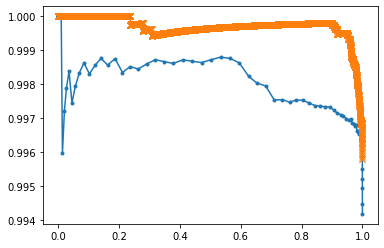

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(recall_brf, precision_brf, marker='.')
plt.plot(recall_eec, precision_eec, marker='x')

### Final Questions

1. Which model had the best balanced accuracy score?

    The Easy Ensemble Classifier model had a better balanced accuracy score than the Balanced Random Forest Classifier(0.931601605553446 > 0.733829270438737)

2. Which model had the best recall score?

    The Easy Ensemble Classifier model had a better average recall score than the Balanced Random Forest Classifier (0.95 > 0.88)

3. Which model had the best geometric mean score?

    The Easy Ensemble Classifier model had a better average recall score than the Balanced Random Forest Classifier (0.94 > 0.84)

4. What are the top three features?

    According to the Balanced Random Forest Classifier, the top three features are: total_rec_prncp, last_pymnt_amnt, total_pymnt